In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib
from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
import sys
sys.path.append("../../src")
from ContrastiveModels import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
criterion = torch.nn.MSELoss(reduction='none').to(device)
architecture = [784, 500, 10]
model = EP(architecture, activation = activation)

In [5]:
lrs = [0.1, 0.05]

In [6]:
optim_params = []
for idx in range(len(model.W)):
    optim_params.append(  {'params': model.W[idx].parameters(), 'lr': lrs[idx]}  )

In [7]:
optimizer = torch.optim.SGD( optim_params, momentum=0.0 )

In [8]:
model = model.to(device)
evaluateEP(model, test_loader, 20, 0.5, device)

Test accuracy :	 0.0629


0.0629

In [9]:
mbs = train_loader.batch_size
start = time.time()
iter_per_epochs = math.ceil(len(train_loader.dataset)/mbs)
betas = (0.0, 1.0)
beta_1, beta_2 = betas
neural_lr = 0.5
train_acc = [10.0]
test_acc = [10.0]
best = 0.0
epoch_sofar = 0
model.train();

In [10]:
trn_acc_list = []
tst_acc_list = []
T1 = 20
T2 = 4
random_sign = True
n_epochs = 25
for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        neurons = model.init_neurons(x.size(0), device)
        neurons = model(x, y, neurons, T1, neural_lr, beta=beta_1, criterion=criterion)
        neurons_1 = copy(neurons)
        if random_sign and (beta_1==0.0):
            rnd_sgn = 2*np.random.randint(2) - 1
            betas = beta_1, rnd_sgn*beta_2
            beta_1, beta_2 = betas

        neurons = model(x, y, neurons, T2, neural_lr, beta = beta_2, criterion=criterion)
        neurons_2 = copy(neurons)
        model.compute_syn_grads(x, y, neurons_1, neurons_2, betas, criterion)
        optimizer.step() 
    trn_acc = evaluateEP(model.to(device), train_loader, T1, neural_lr, device, False)
    tst_acc = evaluateEP(model.to(device), test_loader, T1, neural_lr, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [01:22, 36.27it/s]
2it [00:00, 18.21it/s]

Epoch : 1, Train Accuracy : 0.9606, Test Accuracy : 0.9567


3000it [02:29, 20.04it/s]
2it [00:00, 18.95it/s]

Epoch : 2, Train Accuracy : 0.97105, Test Accuracy : 0.9622


3000it [02:17, 21.79it/s]
2it [00:00, 17.14it/s]

Epoch : 3, Train Accuracy : 0.9801333333333333, Test Accuracy : 0.9685


3000it [02:21, 21.26it/s]
2it [00:00, 18.55it/s]

Epoch : 4, Train Accuracy : 0.98425, Test Accuracy : 0.9716


3000it [02:22, 21.01it/s]
2it [00:00, 17.57it/s]

Epoch : 5, Train Accuracy : 0.9879166666666667, Test Accuracy : 0.9746


3000it [02:22, 21.00it/s]
3it [00:00, 20.58it/s]

Epoch : 6, Train Accuracy : 0.9893, Test Accuracy : 0.9721


3000it [02:22, 21.06it/s]
2it [00:00, 16.99it/s]

Epoch : 7, Train Accuracy : 0.9905333333333334, Test Accuracy : 0.9703


3000it [02:22, 21.09it/s]
3it [00:00, 20.75it/s]

Epoch : 8, Train Accuracy : 0.99065, Test Accuracy : 0.971


3000it [02:23, 20.87it/s]
2it [00:00, 17.43it/s]

Epoch : 9, Train Accuracy : 0.9935833333333334, Test Accuracy : 0.9728


3000it [02:24, 20.79it/s]
2it [00:00, 18.01it/s]

Epoch : 10, Train Accuracy : 0.9959833333333333, Test Accuracy : 0.977


3000it [02:22, 21.10it/s]
2it [00:00, 19.54it/s]

Epoch : 11, Train Accuracy : 0.9963333333333333, Test Accuracy : 0.9753


3000it [02:22, 21.08it/s]
2it [00:00, 18.48it/s]

Epoch : 12, Train Accuracy : 0.99735, Test Accuracy : 0.9755


3000it [02:24, 20.75it/s]
2it [00:00, 19.25it/s]

Epoch : 13, Train Accuracy : 0.9961833333333333, Test Accuracy : 0.9755


3000it [02:24, 20.83it/s]
2it [00:00, 19.40it/s]

Epoch : 14, Train Accuracy : 0.9946, Test Accuracy : 0.9701


3000it [02:22, 20.98it/s]
2it [00:00, 17.60it/s]

Epoch : 15, Train Accuracy : 0.9980333333333333, Test Accuracy : 0.9739


3000it [02:25, 20.65it/s]
2it [00:00, 19.39it/s]

Epoch : 16, Train Accuracy : 0.9988333333333334, Test Accuracy : 0.9756


3000it [02:25, 20.57it/s]
2it [00:00, 19.13it/s]

Epoch : 17, Train Accuracy : 0.99885, Test Accuracy : 0.9741


3000it [02:23, 20.84it/s]
2it [00:00, 19.08it/s]

Epoch : 18, Train Accuracy : 0.9992666666666666, Test Accuracy : 0.976


3000it [02:24, 20.80it/s]
3it [00:00, 20.38it/s]

Epoch : 19, Train Accuracy : 0.99935, Test Accuracy : 0.9751


3000it [02:25, 20.63it/s]
2it [00:00, 18.97it/s]

Epoch : 20, Train Accuracy : 0.9992, Test Accuracy : 0.9753


3000it [02:25, 20.61it/s]
2it [00:00, 18.66it/s]

Epoch : 21, Train Accuracy : 0.99945, Test Accuracy : 0.9749


3000it [02:24, 20.81it/s]
2it [00:00, 18.22it/s]

Epoch : 22, Train Accuracy : 0.9995833333333334, Test Accuracy : 0.9755


3000it [02:23, 20.84it/s]
3it [00:00, 20.44it/s]

Epoch : 23, Train Accuracy : 0.9996, Test Accuracy : 0.9765


3000it [02:24, 20.77it/s]
2it [00:00, 18.48it/s]

Epoch : 24, Train Accuracy : 0.9997166666666667, Test Accuracy : 0.9752


3000it [02:25, 20.60it/s]


Epoch : 25, Train Accuracy : 0.9996833333333334, Test Accuracy : 0.9755


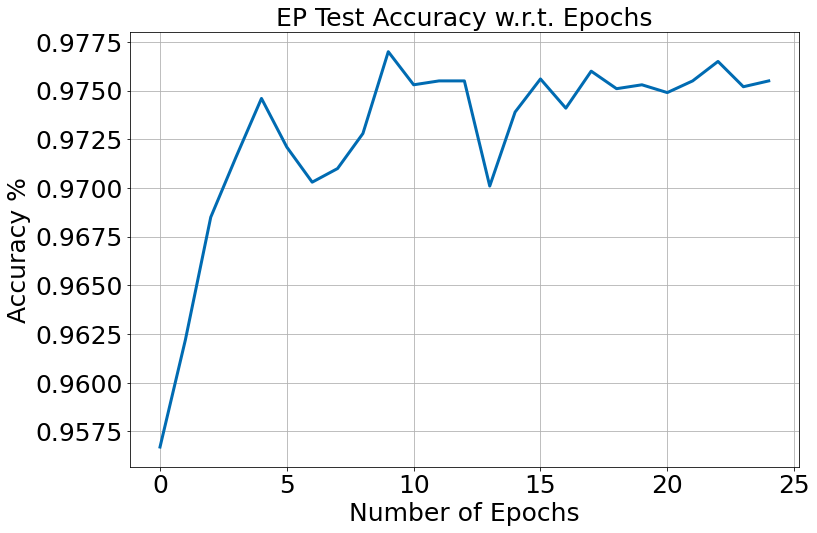

In [12]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'EP Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [13]:
evaluateEP(model.to(device), test_loader, T1, neural_lr, device)

Test accuracy :	 0.9755


0.9755

In [14]:
evaluateEP(model.to(device), train_loader, T1, neural_lr, device)

Train accuracy :	 0.9996833333333334


0.9996833333333334